In [1]:
import warnings

import pandas as pd
import numpy as np
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, f1_score

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
def individual_log_loss(y_true, y_pred, eps=1e-15):
    """Compute log-loss for each individual of the sample."""

    y_pred = np.clip(y_pred, eps, 1 - eps)
    return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)


def shap_sum2proba(shap_sum):
    """Compute sigmoid function of the Shap sum to get predicted probability."""

    return 1 / (1 + np.exp(-shap_sum))


def get_preds_shaps(X_train, X_val, y_train, y_val, is_train=True):
    """Get predictions (predicted probabilities) and SHAP values for a dataset."""
    f1, model = evaluate_model_opt(X_train, X_val, y_train, y_val)

    X = None
    y = None

    if is_train == True:
        X = X_train.copy()
    else:
        X = X_val.copy()

    preds = pd.Series(model.predict_proba(X)[:, 1], index=X.index)
    shap_explainer = TreeExplainer(model)

    shap_values = shap_explainer.shap_values(X)
    shap_expected_value = shap_explainer.expected_value

    shaps = pd.DataFrame(
        data=shap_values,
        index=X.index,
        columns=X.columns)
    return preds, shaps, shap_expected_value


def get_feature_contributions(y_true, y_pred, shap_values, shap_expected_value):
    """Compute prediction contribution and error contribution for each feature."""

    prediction_contribution = shap_values.abs().mean().rename("prediction_contribution")

    ind_log_loss = individual_log_loss(y_true=y_true['result_match'], y_pred=y_pred).rename("log_loss")
    y_pred_wo_feature = shap_values.apply(lambda feature: shap_expected_value + shap_values.sum(axis=1) - feature).applymap(shap_sum2proba)
    ind_log_loss_wo_feature = y_pred_wo_feature.apply(lambda feature: individual_log_loss(y_true=y_true['result_match'], y_pred=feature))
    ind_log_loss_diff = ind_log_loss_wo_feature.apply(lambda feature: ind_log_loss - feature)
    error_contribution = ind_log_loss_diff.mean().rename("error_contribution").T

    return prediction_contribution, error_contribution

In [3]:
def evaluate_model_opt(X_train, X_val, y_train, y_val):
    model = XGBClassifier( random_state=42, enable_categorical=True, scale_pos_weight=2)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, early_stopping_rounds=25)
    y_pred = model.predict(X_val)

    return f1_score(y_val, y_pred), model

In [4]:
X = pd.read_csv('../../data/new_features/df.csv')
y = pd.read_csv('../../data/new_features/y.csv')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
f1, xgb_model = evaluate_model_opt(X_train, X_val, y_train, y_val)

f1

0.6544467073998642

In [6]:
from shap import TreeExplainer

shap_explainer = TreeExplainer(xgb_model)
shap_values = shap_explainer.shap_values(X_train)

In [7]:
preds_train, shaps_train, shap_expected_value_train = get_preds_shaps(X_train, X_val, y_train, y_val, True)
preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train, X_val, y_train, y_val, False)

In [8]:
# assert ((preds_train - (shap_expected_value_train + shaps_train.sum(axis=1)).apply(shap_sum2proba)).abs() < 1e-10).all()
# assert ((preds_val - (shap_expected_value_val + shaps_val.sum(axis=1)).apply(shap_sum2proba)).abs() < 1e-10).all()

In [9]:
prediction_contribution_trn, error_contribution_trn = get_feature_contributions(
    y_true=y_train,
    y_pred=preds_train,
    shap_values=shaps_train,
    shap_expected_value=shap_expected_value_train
)

prediction_contribution_val, error_contribution_val = get_feature_contributions(
    y_true=y_val,
    y_pred=preds_val,
    shap_values=shaps_val,
    shap_expected_value=shap_expected_value_val
)

contributions_trn = pd.concat([prediction_contribution_trn, error_contribution_trn], axis=1)
contributions_val = pd.concat([prediction_contribution_val, error_contribution_val], axis=1)

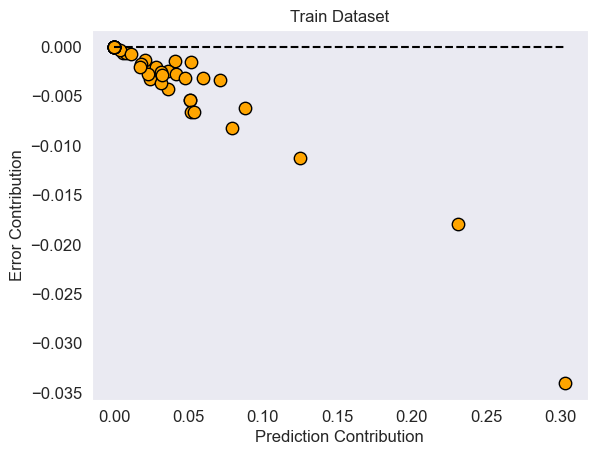

In [10]:
fig, ax = plt.subplots()

ax.scatter(contributions_trn["prediction_contribution"], contributions_trn["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_trn["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid();
ax.set_axisbelow(True)
ax.set_title("Train Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_trn.png", dpi=200, bbox_inches="tight")

In [11]:
pd.set_option("display.max_rows", 10)
contributions_trn.sort_values("prediction_contribution", ascending=False).head(10)

,prediction_contribution,error_contribution
avg_home_rating_attack,0.303161,-0.034039
avg_away_rating_attack,0.231313,-0.017952
ewm_shoton_away,0.124628,-0.011303
ewm_away_team_goals,0.087958,-0.006202
ewm_shoton_home,0.078902,-0.008243
away_streak_wins,0.070846,-0.003376
ewm_possession_home,0.059579,-0.003186
home_weighted_wins,0.053420,-0.006586
ewm_home_team_goals,0.051916,-0.006579
player_rating_away_player_8,0.051362,-0.001576


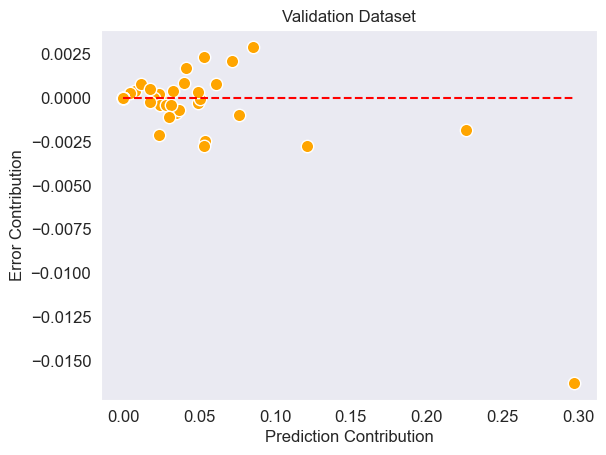

In [12]:
fig, ax = plt.subplots()

ax.scatter(contributions_val["prediction_contribution"], contributions_val["error_contribution"], s=80, color="orange", edgecolors="white")
ax.hlines(y=0, xmin=0, xmax=contributions_val["prediction_contribution"].max(), ls="--", color="red")
ax.tick_params(axis="both", which="major", labelsize=12)

ax.grid()
ax.set_axisbelow(True)
ax.set_title("Validation Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_val.png", dpi=200, bbox_inches="tight")

In [13]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("error_contribution", ascending=True).round(4).head(10)

,prediction_contribution,error_contribution
avg_home_rating_attack,0.2975,-0.0162
home_weighted_wins,0.0529,-0.0028
ewm_shoton_away,0.1209,-0.0027
ewm_home_team_goals,0.0535,-0.0025
home_streak_wins,0.0237,-0.0021
avg_away_rating_attack,0.2261,-0.0018
ewm_possession_away,0.0299,-0.0011
ewm_shoton_home,0.0762,-0.0010
player_rating_home_player_11,0.0349,-0.0009
points_away,0.0364,-0.0007


In [14]:
from tqdm import tqdm
from sklearn.metrics import log_loss, average_precision_score

features = X_train.columns.to_list()
rfe_error = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
    preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train[features_curr], X_val[features_curr], y_train, y_val, False)

    prediction_contribution_val, error_contribution_val = get_feature_contributions(
        y_true=y_val,
        y_pred=preds_val,
        shap_values=shaps_val,
        shap_expected_value=shap_expected_value_val
    )

    rfe_error.loc[iteration, "feature_drop"] = feature_drop
    rfe_error.loc[iteration, "n_features"] = len(features_curr)
    rfe_error.loc[iteration, "contrib"] = error_contribution_val.max()

    rfe_error.loc[iteration, "logloss_trn"] = log_loss(y_train['result_match'], preds_train)
    rfe_error.loc[iteration, "logloss_val"] = log_loss(y_val['result_match'], preds_val)
    # rfe_error.loc[iteration, "logloss_tst"] = log_loss(df.loc[ix_tst, target], preds.loc[ix_tst])

    rfe_error.loc[iteration, "ap_trn"] = average_precision_score(y_train['result_match'], preds_train, average='weighted')
    rfe_error.loc[iteration, "ap_val"] = average_precision_score(y_val['result_match'], preds_val, average='weighted')
    # rfe_error.loc[iteration, "ap_tst"] = average_precision_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    # rfe_error.loc[iteration, "f1_trn"] = f1_score(y_train['result_match'], preds_train, average='binary', pos_label='binary')
    # rfe_error.loc[iteration, "f1_val"] = f1_score(y_val['result_match'], preds_val, average='binary', pos_label='binary')
    # rfe_error.loc[iteration, "f1_tst"] = f1_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    feature_drop = error_contribution_val.idxmax()

    features_curr.remove(feature_drop)

100%|██████████| 46/46 [00:10<00:00,  4.48it/s]


In [15]:
features = X_train.columns.to_list()
rfe_prediction = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
    preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train[features_curr], X_val[features_curr], y_train, y_val, False)

    prediction_contribution_val, error_contribution_val = get_feature_contributions(
        y_true=y_val,
        y_pred=preds_val,
        shap_values=shaps_val,
        shap_expected_value=shap_expected_value_val
    )

    rfe_prediction.loc[iteration, "feature_drop"] = feature_drop
    rfe_prediction.loc[iteration, "n_features"] = len(features_curr)
    rfe_prediction.loc[iteration, "contrib"] = prediction_contribution_val.max()

    rfe_prediction.loc[iteration, "logloss_trn"] = log_loss(y_train['result_match'], preds_train)
    rfe_prediction.loc[iteration, "logloss_val"] = log_loss(y_val['result_match'], preds_val)
    # rfe_prediction.loc[iteration, "logloss_tst"] = log_loss(df.loc[ix_tst, target], preds.loc[ix_tst])
    rfe_prediction.loc[iteration, "ap_trn"] = average_precision_score(y_train['result_match'], preds_train)
    rfe_prediction.loc[iteration, "ap_val"] = average_precision_score(y_val['result_match'], preds_val)
    # rfe_prediction.loc[iteration, "ap_tst"] = average_precision_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    # rfe_prediction.loc[iteration, "f1_trn"] = f1_score(y_train['result_match'], preds_train, average='weighted'))
    # rfe_prediction.loc[iteration, "f1_val"] = f1_score(y_val['result_match'], preds_val, average='weighted'))
    # rfe_prediction.loc[iteration, "f1_tst"] = f1_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    feature_drop = prediction_contribution_val.idxmax()

    features_curr.remove(feature_drop)

100%|██████████| 46/46 [00:10<00:00,  4.41it/s]


In [16]:
max_iter_show = len(features) - 5

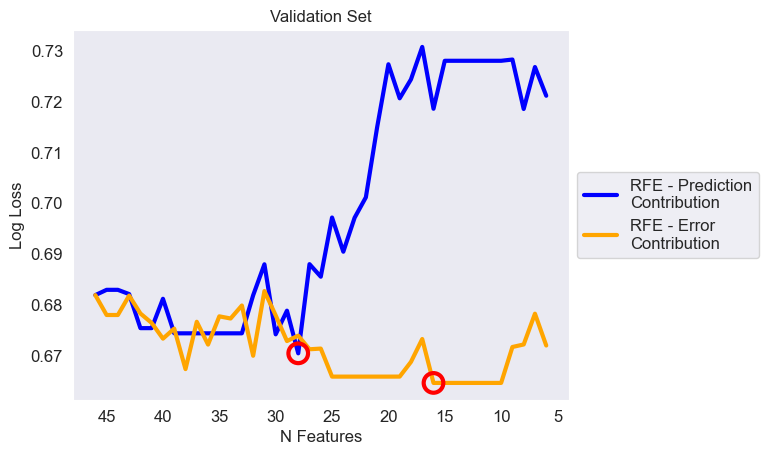

In [17]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["logloss_val"].idxmin()
idxmin_error = rfe_error["logloss_val"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["logloss_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["logloss_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction, "n_features"], rfe_prediction.loc[idxmin_prediction, "logloss_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error, "n_features"], rfe_error.loc[idxmin_error, "logloss_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Validation Set", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_logloss_val_.png", dpi=200, bbox_inches="tight")

In [18]:
rfe_error.sort_values("logloss_val", ascending=True).head(10)

,feature_drop,n_features,contrib,logloss_trn,logloss_val,ap_trn,ap_val
36,avg_home_rating_defence,10.0,-2.548451e-04,0.538525,0.664618,0.850644,0.692238
35,player_rating_home_player_6,11.0,7.498329e-09,0.538525,0.664618,0.850644,0.692238
34,player_rating_home_player_5,12.0,8.047034e-09,0.538525,0.664618,0.850644,0.692238
33,player_rating_home_player_4,13.0,7.620710e-09,0.538525,0.664618,0.850644,0.692238
32,player_rating_home_player_3,14.0,7.245406e-09,0.538525,0.664618,0.850644,0.692238
31,player_rating_home_player_2,15.0,7.305554e-09,0.538525,0.664618,0.850644,0.692238
30,player_rating_away_player_11,16.0,8.166126e-09,0.538525,0.664618,0.850644,0.692238
22,player_rating_away_player_1,24.0,2.448696e-04,0.538525,0.665859,0.850644,0.686973
21,average_rating_home,25.0,2.448693e-04,0.538525,0.665859,0.850644,0.686973
23,player_rating_away_player_2,23.0,2.448701e-04,0.538525,0.665859,0.850644,0.686973


In [19]:
X

,player_rating_home_player_1,player_rating_home_player_2,player_rating_home_player_3,player_rating_home_player_4,player_rating_home_player_5,player_rating_home_player_6,player_rating_home_player_7,player_rating_home_player_8,player_rating_home_player_9,player_rating_home_player_10,...,ewm_possession_home,ewm_possession_away,avg_home_rating_attack,avg_away_rating_attack,avg_away_rating_defence,avg_home_rating_defence,average_rating_home,average_rating_away,defensive_weakness_home,defensive_weakness_away
0,72,72,72,72,72,72,79,75,85,87,...,NaN,NaN,78.50,71.50,71.0,72.0,75.545455,71.272727,NaN,NaN
1,79,79,79,79,79,79,78,75,74,81,...,NaN,NaN,75.83,82.33,84.0,79.0,77.272727,83.090909,NaN,NaN
2,77,77,77,77,77,77,72,82,76,73,...,NaN,NaN,76.33,73.50,76.0,77.0,76.636364,74.636364,NaN,NaN
3,82,82,82,82,82,82,72,73,77,73,...,NaN,NaN,76.33,77.50,73.0,82.0,78.909091,75.454545,NaN,NaN
4,77,77,77,77,77,77,67,75,82,84,...,NaN,NaN,77.00,79.33,84.0,77.0,77.000000,81.454545,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,80,80,80,80,80,80,79,75,80,51,...,48.654,52.130,74.50,73.33,74.0,80.0,77.000000,73.636364,3.012987,2.091358
6075,86,86,86,86,86,86,83,83,83,88,...,47.796,52.362,82.83,75.50,76.0,86.0,84.272727,75.727273,2.017260,1.003601
6076,79,79,79,79,79,79,81,86,88,85,...,43.500,52.919,83.50,74.67,76.0,79.0,81.454545,75.272727,1.129464,2.550725
6077,77,77,77,77,77,77,76,75,75,79,...,50.032,45.678,76.50,80.83,80.0,77.0,76.727273,80.454545,2.124408,2.075706


In [20]:
results = pd.DataFrame(columns=["feature_set",
                                "len_set",
                                "preds_corr_bs",
                                "ap_from_shaps_bs",
                                "ap_from_model_bs",
                                "roc_from_shaps_bs",
                                "roc_from_model_bs"])

feature_sets = []

# Generate random feature sets
for enum in range(50):
    row_id = "_" + str(enum+1).zfill(2)
    while True:
        feature_set = sorted(np.random.choice(X_train.columns, replace=False, size=np.random.randint(1, len(X_train.columns))))
        if feature_set not in feature_sets:
            feature_sets.append(feature_set)
            results.loc[row_id, :] = feature_set, len(feature_set), [], [], [], [], []
            break

for bootstrap_iter in range(5):
    # Get predictions, SHAP values, and SHAP expected value
    preds, shaps, shaps_ev = get_preds_shaps(X_train, X_val, y_train, y_val, False)

    # Save results of the full model using a fixed identifier for the full feature set row
    full_model_row_id = "_00"
    if full_model_row_id not in results.index:
        results.loc[full_model_row_id, :] = sorted(X_train.columns), len(X_train.columns), [], [], [], [], []
    results.at[full_model_row_id, "ap_from_shaps_bs"].append(average_precision_score(y_val, preds))
    results.at[full_model_row_id, "ap_from_model_bs"].append(average_precision_score(y_val, preds))
    results.at[full_model_row_id, "roc_from_shaps_bs"].append(roc_auc_score(y_val, preds))
    results.at[full_model_row_id, "roc_from_model_bs"].append(roc_auc_score(y_val, preds))

    for enum, feature_set in enumerate(feature_sets):
        row_id = "_" + str(enum+1).zfill(2)

        # Compute predictions as estimated from the SHAP values
        preds_from_shaps = shap_sum2proba(shap_sum=shaps_ev + shaps[feature_set].sum(axis=1))

        # Get predictions from model trained on the feature set
        preds_from_model = pd.Series(
            XGBClassifier(random_state=42, enable_categorical=True, scale_pos_weight=2).fit(X_train[feature_set], y_train).predict_proba(X_val[feature_set])[:, 1],
            index=X_val.index
        )

        results.at[row_id, "preds_corr_bs"].append(preds_from_shaps.corr(preds_from_model))
        results.at[row_id, "ap_from_shaps_bs"].append(average_precision_score(y_val, preds_from_shaps))
        results.at[row_id, "ap_from_model_bs"].append(average_precision_score(y_val, preds_from_model))
        results.at[row_id, "roc_from_shaps_bs"].append(roc_auc_score(y_val, preds_from_shaps))
        results.at[row_id, "roc_from_model_bs"].append(roc_auc_score(y_val, preds_from_model))

# Calculate mean values for bootstrap results
results["preds_corr"] = results["preds_corr_bs"].apply(np.mean)
results["ap_from_shaps"] = results["ap_from_shaps_bs"].apply(np.mean)
results["ap_from_model"] = results["ap_from_model_bs"].apply(np.mean)
results["roc_from_shaps"] = results["roc_from_shaps_bs"].apply(np.mean)
results["roc_from_model"] = results["roc_from_model_bs"].apply(np.mean)

In [21]:
results

,feature_set,len_set,preds_corr_bs,ap_from_shaps_bs,ap_from_model_bs,roc_from_shaps_bs,roc_from_model_bs,preds_corr,ap_from_shaps,ap_from_model,roc_from_shaps,roc_from_model
_01,"[average_rating_away, average_rating_home, avg...",36,"[0.7707623091615821, 0.7707623091615821, 0.770...","[0.6589804789402907, 0.6589804789402907, 0.658...","[0.6571228554510116, 0.6571228554510116, 0.657...","[0.6658373465373397, 0.6658373465373397, 0.665...","[0.6654032422166452, 0.6654032422166452, 0.665...",0.770762,0.658980,0.657123,0.665837,0.665403
_02,"[average_rating_away, avg_away_rating_attack, ...",32,"[0.6900020770048215, 0.6900020770048215, 0.690...","[0.6231771197608721, 0.6231771197608721, 0.623...","[0.6502905606667876, 0.6502905606667876, 0.650...","[0.6502123041443397, 0.6502123041443397, 0.650...","[0.6518944583870312, 0.6518944583870312, 0.651...",0.690002,0.623177,0.650291,0.650212,0.651894
_03,"[average_rating_home, avg_away_rating_attack, ...",15,"[0.5896831670340488, 0.5896831670340488, 0.589...","[0.5752832297680261, 0.5752832297680261, 0.575...","[0.6471114757407206, 0.6471114757407206, 0.647...","[0.6334368853014991, 0.6334368853014991, 0.633...","[0.660899409889439, 0.660899409889439, 0.66089...",0.589683,0.575283,0.647111,0.633437,0.660899
_04,[avg_home_team_rating],1,"[0.47694627141455015, 0.47694627141455015, 0.4...","[0.5289409300168485, 0.5289409300168485, 0.528...","[0.6297798687806886, 0.6297798687806886, 0.629...","[0.6080404259648647, 0.6080404259648647, 0.608...","[0.6308363291053382, 0.6308363291053382, 0.630...",0.476946,0.528941,0.629780,0.608040,0.630836
_05,"[avg_away_rating_attack, avg_home_rating_attac...",17,"[0.7002074297142472, 0.7002074297142472, 0.700...","[0.6578184622596661, 0.6578184622596661, 0.657...","[0.6528587533905359, 0.6528587533905359, 0.652...","[0.6693834362070135, 0.6693834362070135, 0.669...","[0.6562680594180288, 0.6562680594180288, 0.656...",0.700207,0.657818,0.652859,0.669383,0.656268
...,...,...,...,...,...,...,...,...,...,...,...,...
_47,"[average_rating_away, average_rating_home, avg...",18,"[0.611095619133241, 0.611095619133241, 0.61109...","[0.6128231018610808, 0.6128231018610808, 0.612...","[0.6559048343985256, 0.6559048343985256, 0.655...","[0.6374414976599063, 0.6374414976599063, 0.637...","[0.6584792783015669, 0.6584792783015669, 0.658...",0.611096,0.612823,0.655905,0.637441,0.658479
_48,"[average_rating_home, avg_away_rating_attack, ...",34,"[0.7582056762339706, 0.7582056762339706, 0.758...","[0.651451451315461, 0.651451451315461, 0.65145...","[0.6417582027201556, 0.6417582027201556, 0.641...","[0.667017567659228, 0.667017567659228, 0.66701...","[0.6492437088787899, 0.6492437088787899, 0.649...",0.758206,0.651451,0.641758,0.667018,0.649244
_49,"[away_streak_wins, defensive_weakness_home, ew...",6,"[0.5224175026900584, 0.5224175026900584, 0.522...","[0.5152926798165359, 0.5152926798165359, 0.515...","[0.6165228587301216, 0.6165228587301216, 0.616...","[0.5806063894729703, 0.5806063894729703, 0.580...","[0.6448673946957878, 0.6448673946957878, 0.644...",0.522418,0.515293,0.616523,0.580606,0.644867
_50,"[player_rating_away_player_3, player_rating_aw...",3,"[nan, nan, nan, nan, nan]","[0.47286184210526316, 0.47286184210526316, 0.4...","[0.622386025857258, 0.622386025857258, 0.62238...","[0.5, 0.5, 0.5, 0.5, 0.5]","[0.6478776368446042, 0.6478776368446042, 0.647...",NaN,0.472862,0.622386,0.500000,0.647878


In [22]:
# Calculate Spearman correlation between 'ap_from_shaps' and 'ap_from_model'
spearman_corr = results["ap_from_shaps"].corr(results["ap_from_model"], method="spearman")

# Format the correlation as a percentage and round to the nearest whole number
formatted_corr = f"{int(round(spearman_corr * 100, 0))}%"

print(formatted_corr)

56%


In [23]:
results['feature_set'][0]

['average_rating_away',
 'average_rating_home',
 'avg_away_rating_attack',
 'avg_away_rating_defence',
 'avg_away_team_rating',
 'avg_home_rating_attack',
 'avg_home_rating_defence',
 'avg_home_team_rating',
 'away_streak_wins',
 'defensive_weakness_away',
 'ewm_away_team_goals',
 'ewm_away_team_goals_conceded',
 'ewm_home_team_goals',
 'ewm_home_team_goals_conceded',
 'ewm_possession_away',
 'ewm_shoton_away',
 'ewm_shoton_home',
 'home_streak_wins',
 'home_weighted_wins',
 'player_rating_away_player_1',
 'player_rating_away_player_10',
 'player_rating_away_player_11',
 'player_rating_away_player_2',
 'player_rating_away_player_3',
 'player_rating_away_player_4',
 'player_rating_away_player_5',
 'player_rating_away_player_7',
 'player_rating_away_player_8',
 'player_rating_home_player_1',
 'player_rating_home_player_11',
 'player_rating_home_player_2',
 'player_rating_home_player_3',
 'player_rating_home_player_5',
 'player_rating_home_player_6',
 'player_rating_home_player_7',
 'play

In [24]:
# Add columns for accuracy and roc_auc metrics
results['f1'] = None

for index, row in results.iterrows():
    feature_set = row['feature_set']
    f1, model = evaluate_model_opt(X_train[feature_set], X_val[feature_set], y_train, y_val)
    
    # Update the results DataFrame with the performance metrics
    results.at[index, 'f1'] = f1


In [25]:
results[['feature_set', 'f1']]

,feature_set,f1
_01,"[average_rating_away, average_rating_home, avg...",0.652576
_02,"[average_rating_away, avg_away_rating_attack, ...",0.660092
_03,"[average_rating_home, avg_away_rating_attack, ...",0.65428
_04,[avg_home_team_rating],0.629429
_05,"[avg_away_rating_attack, avg_home_rating_attac...",0.643929
...,...,...
_47,"[average_rating_away, average_rating_home, avg...",0.655957
_48,"[average_rating_home, avg_away_rating_attack, ...",0.651255
_49,"[away_streak_wins, defensive_weakness_home, ew...",0.663683
_50,"[player_rating_away_player_3, player_rating_aw...",0.663372


In [26]:
best_feature_set = results.loc[results['f1'].idxmax()]['feature_set']

In [27]:
import os
import json

output_dir = "../data/feature_selection/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

X[best_feature_set].to_csv(output_dir + 'df.csv', index=False)
y.to_csv(output_dir + 'y.csv', index=False)

In [28]:
evaluate_model_opt(X_train[best_feature_set], X_val[best_feature_set], y_train, y_val)

(0.6706746826987308,
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=True, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...))